In [1]:
# pipenv install pandas scipy plotly scikit-learn optuna shap ipywidgets nbformat numpy==2.0

In [90]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

import plotly.express as px

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss, roc_curve, roc_auc_score, f1_score, precision_score, recall_score

import optuna

In [2]:
pd.__version__ 

'2.2.3'

In [3]:
df = pd.read_csv('dataset.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         2000 non-null   object 
 1   idade                      2000 non-null   int64  
 2   genero                     2000 non-null   object 
 3   estado_civil               2000 non-null   object 
 4   educacao                   2000 non-null   object 
 5   regime_trabalho            2000 non-null   object 
 6   data_contratacao           2000 non-null   object 
 7   data_demissao              286 non-null    object 
 8   tipo_demissao              286 non-null    object 
 9   cargo                      2000 non-null   object 
 10  salario_atual              2000 non-null   int64  
 11  data_ultimo_feedback       2000 non-null   object 
 12  data_ultimo_aumento        2000 non-null   object 
 13  data_ultima_mudanca_cargo  2000 non-null   objec

In [5]:
df.head()

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,salario_atual,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn
0,EMP1564,37,F,Divorciado(a),Master,Remoto,2020-01-02,NaN,NaN,Senior Developer,10207,2024-05-09,2023-07-31,2022-11-03,9.6,True,5,1,7.0,0
1,EMP0959,45,Outro,Divorciado(a),Master,Remoto,2020-01-03,NaN,NaN,UX Designer,23921,2024-04-05,2023-09-10,2022-02-11,8.4,True,8,4,9.1,0
2,EMP0494,54,M,Viúvo(a),Technical Degree,Híbrido,2020-01-04,NaN,NaN,Tech Lead,15298,2023-06-16,2021-12-26,2021-05-10,8.5,False,9,7,1.3,0
3,EMP1231,44,M,Casado(a),Bachelor,Remoto,2020-01-05,NaN,NaN,QA Engineer,15306,2021-12-04,2022-01-01,2024-08-30,7.9,False,8,4,8.4,0
4,EMP1912,53,Outro,Viúvo(a),PhD,Presencial,2020-01-07,NaN,NaN,Senior Developer,17723,2022-03-04,2023-11-18,2024-08-08,7.5,True,5,2,8.2,0


In [6]:
df['data_contratacao'] = pd.to_datetime(df['data_contratacao'], format="%Y-%m-%d")
df['data_demissao'] = pd.to_datetime(df['data_demissao'], format='%Y-%m-%d')
df['data_ultimo_feedback'] = pd.to_datetime(df['data_ultimo_feedback'], format='%Y-%m-%d')
df['data_ultimo_aumento'] = pd.to_datetime(df['data_ultimo_aumento'], format='%Y-%m-%d')
df['data_ultima_mudanca_cargo'] = pd.to_datetime(df['data_ultima_mudanca_cargo'], format='%Y-%m-%d')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         2000 non-null   object        
 1   idade                      2000 non-null   int64         
 2   genero                     2000 non-null   object        
 3   estado_civil               2000 non-null   object        
 4   educacao                   2000 non-null   object        
 5   regime_trabalho            2000 non-null   object        
 6   data_contratacao           2000 non-null   datetime64[ns]
 7   data_demissao              286 non-null    datetime64[ns]
 8   tipo_demissao              286 non-null    object        
 9   cargo                      2000 non-null   object        
 10  salario_atual              2000 non-null   int64         
 11  data_ultimo_feedback       2000 non-null   datetime64[ns]
 12  data_u

In [8]:
df.head()

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,salario_atual,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn
0,EMP1564,37,F,Divorciado(a),Master,Remoto,2020-01-02,NaT,NaN,Senior Developer,10207,2024-05-09,2023-07-31,2022-11-03,9.6,True,5,1,7.0,0
1,EMP0959,45,Outro,Divorciado(a),Master,Remoto,2020-01-03,NaT,NaN,UX Designer,23921,2024-04-05,2023-09-10,2022-02-11,8.4,True,8,4,9.1,0
2,EMP0494,54,M,Viúvo(a),Technical Degree,Híbrido,2020-01-04,NaT,NaN,Tech Lead,15298,2023-06-16,2021-12-26,2021-05-10,8.5,False,9,7,1.3,0
3,EMP1231,44,M,Casado(a),Bachelor,Remoto,2020-01-05,NaT,NaN,QA Engineer,15306,2021-12-04,2022-01-01,2024-08-30,7.9,False,8,4,8.4,0
4,EMP1912,53,Outro,Viúvo(a),PhD,Presencial,2020-01-07,NaT,NaN,Senior Developer,17723,2022-03-04,2023-11-18,2024-08-08,7.5,True,5,2,8.2,0


In [10]:
df[df['data_contratacao'] == '2020-01-02']

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,salario_atual,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn
0,EMP1564,37,F,Divorciado(a),Master,Remoto,2020-01-02,NaT,NaN,Senior Developer,10207,2024-05-09,2023-07-31,2022-11-03,9.6,True,5,1,7.0,0


In [11]:
df.describe()

,idade,data_contratacao,data_demissao,salario_atual,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn
count,2000.000000,2000,286,2000.000000,2000,2000,2000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000
mean,37.938500,2022-04-13 08:03:07.200000,2023-07-31 15:11:19.720279808,14801.834500,2023-06-24 02:25:26.400000,2023-06-10 23:52:48.000000256,2023-06-23 20:43:26.400000,7.997550,4.984500,3.998500,5.492450,0.14300
min,22.000000,2020-01-02 00:00:00,2020-08-22 00:00:00,5016.000000,2020-02-08 00:00:00,2020-03-26 00:00:00,2020-02-15 00:00:00,6.000000,1.000000,1.000000,1.000000,0.00000
25%,30.000000,2021-02-12 00:00:00,2022-11-03 12:00:00,9844.250000,2022-10-27 18:00:00,2022-09-24 18:00:00,2022-11-03 00:00:00,7.000000,3.000000,2.000000,3.300000,0.00000
50%,38.000000,2022-04-05 00:00:00,2023-12-11 12:00:00,14822.500000,2023-10-03 12:00:00,2023-09-19 00:00:00,2023-10-12 00:00:00,8.000000,5.000000,4.000000,5.500000,0.00000
75%,46.000000,2023-06-14 06:00:00,2024-06-10 18:00:00,19702.500000,2024-05-19 06:00:00,2024-05-13 06:00:00,2024-05-15 06:00:00,9.000000,7.000000,6.000000,7.700000,0.00000
max,54.000000,2024-07-25 00:00:00,2024-10-21 00:00:00,24988.000000,2024-10-23 00:00:00,2024-10-22 00:00:00,2024-10-23 00:00:00,10.000000,9.000000,7.000000,10.000000,1.00000
std,9.456132,NaN,NaN,5763.451836,NaN,NaN,NaN,1.157324,2.593188,1.987076,2.609817,0.35016


In [16]:
df['tempo_empresa'] = df.apply(lambda x: (x['data_demissao'] - x['data_contratacao']).days if x['churn'] == 1 else (pd.Timestamp.now() - x['data_contratacao']).days, axis=1)

In [17]:
df.head()

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,...,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn,tempo_empresa
0,EMP1564,37,F,Divorciado(a),Master,Remoto,2020-01-02,NaT,NaN,Senior Developer,...,2024-05-09,2023-07-31,2022-11-03,9.6,True,5,1,7.0,0,1867
1,EMP0959,45,Outro,Divorciado(a),Master,Remoto,2020-01-03,NaT,NaN,UX Designer,...,2024-04-05,2023-09-10,2022-02-11,8.4,True,8,4,9.1,0,1866
2,EMP0494,54,M,Viúvo(a),Technical Degree,Híbrido,2020-01-04,NaT,NaN,Tech Lead,...,2023-06-16,2021-12-26,2021-05-10,8.5,False,9,7,1.3,0,1865
3,EMP1231,44,M,Casado(a),Bachelor,Remoto,2020-01-05,NaT,NaN,QA Engineer,...,2021-12-04,2022-01-01,2024-08-30,7.9,False,8,4,8.4,0,1864
4,EMP1912,53,Outro,Viúvo(a),PhD,Presencial,2020-01-07,NaT,NaN,Senior Developer,...,2022-03-04,2023-11-18,2024-08-08,7.5,True,5,2,8.2,0,1862


In [18]:
df[df['churn'] == 1].head()

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,...,data_ultimo_feedback,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn,tempo_empresa
6,EMP1152,29,M,Casado(a),PhD,Presencial,2020-01-10,2022-08-22,Involuntária,Product Manager,...,2020-10-16,2020-08-11,2022-02-27,9.1,True,6,3,1.9,1,955
12,EMP0734,46,Outro,Viúvo(a),Bachelor,Remoto,2020-01-14,2022-06-06,Voluntária,Junior Developer,...,2020-06-02,2022-05-25,2021-10-20,8.9,True,1,1,5.4,1,874
19,EMP1885,25,Outro,Viúvo(a),Technical Degree,Híbrido,2020-01-22,2023-11-29,Involuntária,UX Designer,...,2020-02-08,2020-06-09,2020-02-15,8.3,False,6,2,3.5,1,1407
20,EMP1852,46,F,Casado(a),Technical Degree,Remoto,2020-01-23,2022-10-09,Involuntária,Senior Developer,...,2021-05-01,2021-06-30,2022-08-07,6.6,True,3,4,9.0,1,990
25,EMP1079,36,Outro,Viúvo(a),Master,Híbrido,2020-01-26,2024-07-23,Involuntária,Product Manager,...,2023-12-30,2023-07-25,2023-05-13,7.0,True,9,5,6.8,1,1640


In [19]:
df['tempo_desde_ultimo_feedback'] = df.apply(lambda x: (pd.Timestamp.now() - x['data_ultimo_feedback']).days, axis=1)

In [20]:
df.head()

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,...,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn,tempo_empresa,tempo_desde_ultimo_feedback
0,EMP1564,37,F,Divorciado(a),Master,Remoto,2020-01-02,NaT,NaN,Senior Developer,...,2023-07-31,2022-11-03,9.6,True,5,1,7.0,0,1867,278
1,EMP0959,45,Outro,Divorciado(a),Master,Remoto,2020-01-03,NaT,NaN,UX Designer,...,2023-09-10,2022-02-11,8.4,True,8,4,9.1,0,1866,312
2,EMP0494,54,M,Viúvo(a),Technical Degree,Híbrido,2020-01-04,NaT,NaN,Tech Lead,...,2021-12-26,2021-05-10,8.5,False,9,7,1.3,0,1865,606
3,EMP1231,44,M,Casado(a),Bachelor,Remoto,2020-01-05,NaT,NaN,QA Engineer,...,2022-01-01,2024-08-30,7.9,False,8,4,8.4,0,1864,1165
4,EMP1912,53,Outro,Viúvo(a),PhD,Presencial,2020-01-07,NaT,NaN,Senior Developer,...,2023-11-18,2024-08-08,7.5,True,5,2,8.2,0,1862,1075


In [21]:
df.tail()

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,...,data_ultimo_aumento,data_ultima_mudanca_cargo,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn,tempo_empresa,tempo_desde_ultimo_feedback
1995,EMP0353,50,Outro,Viúvo(a),Bachelor,Remoto,2024-07-23,NaT,NaN,QA Engineer,...,2024-09-03,2024-08-10,9.3,True,6,3,10.0,0,203,174
1996,EMP1808,26,F,Divorciado(a),PhD,Presencial,2024-07-24,2024-10-06,Voluntária,Senior Developer,...,2024-09-17,2024-10-04,9.9,False,4,6,4.7,1,74,147
1997,EMP0503,35,F,Viúvo(a),PhD,Presencial,2024-07-24,NaT,NaN,Senior Developer,...,2024-08-15,2024-10-19,8.0,False,6,1,6.8,0,202,120
1998,EMP1266,33,F,Viúvo(a),Technical Degree,Híbrido,2024-07-25,NaT,NaN,QA Engineer,...,2024-08-07,2024-10-11,8.7,False,8,1,2.6,0,201,144
1999,EMP1815,53,F,Solteiro(a),PhD,Presencial,2024-07-25,NaT,NaN,QA Engineer,...,2024-09-11,2024-09-04,7.9,False,9,2,2.3,0,201,125


In [22]:
df['dias_desde_ultimo_aumento'] = df.apply(lambda x: (pd.Timestamp.now() - x['data_ultimo_aumento']).days, axis=1)

In [23]:
df['dias_desde_ultima_mudanca_cargo'] = df.apply(lambda x: (pd.Timestamp.now() - x['data_ultima_mudanca_cargo']).days, axis=1)

In [24]:
df.tail()

,id,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,...,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn,tempo_empresa,tempo_desde_ultimo_feedback,dias_desde_ultimo_aumento,dias_desde_ultima_mudanca_cargo
1995,EMP0353,50,Outro,Viúvo(a),Bachelor,Remoto,2024-07-23,NaT,NaN,QA Engineer,...,9.3,True,6,3,10.0,0,203,174,161,185
1996,EMP1808,26,F,Divorciado(a),PhD,Presencial,2024-07-24,2024-10-06,Voluntária,Senior Developer,...,9.9,False,4,6,4.7,1,74,147,147,130
1997,EMP0503,35,F,Viúvo(a),PhD,Presencial,2024-07-24,NaT,NaN,Senior Developer,...,8.0,False,6,1,6.8,0,202,120,180,115
1998,EMP1266,33,F,Viúvo(a),Technical Degree,Híbrido,2024-07-25,NaT,NaN,QA Engineer,...,8.7,False,8,1,2.6,0,201,144,188,123
1999,EMP1815,53,F,Solteiro(a),PhD,Presencial,2024-07-25,NaT,NaN,QA Engineer,...,7.9,False,9,2,2.3,0,201,125,153,160


In [26]:
df.drop(columns=['id'], inplace=True, axis=1)

In [27]:
df.head()

,idade,genero,estado_civil,educacao,regime_trabalho,data_contratacao,data_demissao,tipo_demissao,cargo,salario_atual,...,nota_avaliacao,acompanhamento_psicologo,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn,tempo_empresa,tempo_desde_ultimo_feedback,dias_desde_ultimo_aumento,dias_desde_ultima_mudanca_cargo
0,37,F,Divorciado(a),Master,Remoto,2020-01-02,NaT,NaN,Senior Developer,10207,...,9.6,True,5,1,7.0,0,1867,278,561,831
1,45,Outro,Divorciado(a),Master,Remoto,2020-01-03,NaT,NaN,UX Designer,23921,...,8.4,True,8,4,9.1,0,1866,312,520,1096
2,54,M,Viúvo(a),Technical Degree,Híbrido,2020-01-04,NaT,NaN,Tech Lead,15298,...,8.5,False,9,7,1.3,0,1865,606,1143,1373
3,44,M,Casado(a),Bachelor,Remoto,2020-01-05,NaT,NaN,QA Engineer,15306,...,7.9,False,8,4,8.4,0,1864,1165,1137,165
4,53,Outro,Viúvo(a),PhD,Presencial,2020-01-07,NaT,NaN,Senior Developer,17723,...,7.5,True,5,2,8.2,0,1862,1075,451,187


### EDA

In [28]:
df.isnull().sum()

idade                                 0
genero                                0
estado_civil                          0
educacao                              0
regime_trabalho                       0
data_contratacao                      0
data_demissao                      1714
tipo_demissao                      1714
cargo                                 0
salario_atual                         0
data_ultimo_feedback                  0
data_ultimo_aumento                   0
data_ultima_mudanca_cargo             0
nota_avaliacao                        0
acompanhamento_psicologo              0
qtde_projetos                         0
qtde_clientes                         0
nivel_satisfacao_gestor               0
churn                                 0
tempo_empresa                         0
tempo_desde_ultimo_feedback           0
dias_desde_ultimo_aumento             0
dias_desde_ultima_mudanca_cargo       0
dtype: int64

In [29]:
df['churn'].value_counts()

churn
0    1714
1     286
Name: count, dtype: int64

In [33]:
fig = px.bar(df['churn'].value_counts() / len(df) * 100, title='Fator de Churn')
fig.show()

In [36]:
for col in df.select_dtypes(include=['object']).columns:
  print(f"Valores únicos na coluna {col}:", df[col].unique())

Valores únicos na coluna genero: ['F' 'Outro' 'M']
Valores únicos na coluna estado_civil: ['Divorciado(a)' 'Viúvo(a)' 'Casado(a)' 'Solteiro(a)']
Valores únicos na coluna educacao: ['Master' 'Technical Degree' 'Bachelor' 'PhD']
Valores únicos na coluna regime_trabalho: ['Remoto' 'Híbrido' 'Presencial']
Valores únicos na coluna tipo_demissao: [nan 'Involuntária' 'Voluntária']
Valores únicos na coluna cargo: ['Senior Developer' 'UX Designer' 'Tech Lead' 'QA Engineer'
 'Junior Developer' 'Product Manager' 'DevOps Engineer' 'Data Scientist']


In [37]:
df.select_dtypes(include=['int64', 'float64']).describe()

,idade,salario_atual,nota_avaliacao,qtde_projetos,qtde_clientes,nivel_satisfacao_gestor,churn,tempo_empresa,tempo_desde_ultimo_feedback,dias_desde_ultimo_aumento,dias_desde_ultima_mudanca_cargo
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.00000,2000.000000,2000.000000
mean,37.938500,14801.834500,7.997550,4.984500,3.998500,5.492450,0.14300,954.532000,597.89900,611.005000,598.136500
std,9.456132,5763.451836,1.157324,2.593188,1.987076,2.609817,0.35016,501.389699,395.59628,397.623967,395.911115
min,22.000000,5016.000000,6.000000,1.000000,1.000000,1.000000,0.00000,34.000000,111.00000,112.000000,111.000000
25%,30.000000,9844.250000,7.000000,3.000000,2.000000,3.300000,0.00000,525.000000,267.75000,273.750000,271.750000
50%,38.000000,14822.500000,8.000000,5.000000,4.000000,5.500000,0.00000,950.500000,496.50000,511.000000,488.000000
75%,46.000000,19702.500000,9.000000,7.000000,6.000000,7.700000,0.00000,1381.250000,837.25000,870.250000,831.000000
max,54.000000,24988.000000,10.000000,9.000000,7.000000,10.000000,1.00000,1867.000000,1830.00000,1783.000000,1823.000000


In [39]:
for col in df.select_dtypes(include=['int64', 'float64']).columns:
  if col != 'churn':
    fig = px.box(df, x='churn', y=col, title=f'Boxplot da coluna {col}', color='churn')
    fig.show()

In [44]:
colunas_numericas = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[colunas_numericas].corr()

fig = px.imshow(corr_matrix, title='Matriz de Correlação', color_continuous_scale='Viridis', zmin=-1, zmax=1)

fig.update_traces(text=corr_matrix, texttemplate='%{text:.1%}', textfont={'size': 12})
fig.update_layout(width=1000, height=800, title_font=dict(size=14), font=dict(size=10))

fig.show()

In [46]:
fig = px.scatter_matrix(df, dimensions=colunas_numericas, color='churn', title='Scatter Matrix')
fig.update_layout(width=1200, height=1000, title_font=dict(size=14), font=dict(size=10))

fig.show()

In [47]:
colunas_categoricas = df.select_dtypes(include=['object']).columns
for col in colunas_categoricas:
  contigency_table = pd.crosstab(df[col], df['churn'])
  chi2, p_value, dof, expected = chi2_contingency(contigency_table)
  print(f'\nTeste Chi-quadrado para {col} vs Churn')
  print(f'p-value: {p_value}')
  if p_value <= 0.05:
    print('Variáveis são dependentes')
  else:
    print('Variáveis são independentes')


Teste Chi-quadrado para genero vs Churn
p-value: 0.6391382063144609
Variáveis são independentes

Teste Chi-quadrado para estado_civil vs Churn
p-value: 0.8332629331272039
Variáveis são independentes

Teste Chi-quadrado para educacao vs Churn
p-value: 0.2047514912138827
Variáveis são independentes

Teste Chi-quadrado para regime_trabalho vs Churn
p-value: 0.9751275918764937
Variáveis são independentes

Teste Chi-quadrado para tipo_demissao vs Churn
p-value: 1.0
Variáveis são independentes

Teste Chi-quadrado para cargo vs Churn
p-value: 0.4586024122014407
Variáveis são independentes


In [49]:
for col in colunas_categoricas:
  fig = px.histogram(df, x=col, color='churn', title=f'Histograma da coluna {col}', barmode='group')
  fig.show()

### PREPARACAO DOS DADOS

In [50]:
colunas_datas = df.select_dtypes(include=['datetime64']).columns
df.drop(columns=colunas_datas, inplace=True)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   idade                            2000 non-null   int64  
 1   genero                           2000 non-null   object 
 2   estado_civil                     2000 non-null   object 
 3   educacao                         2000 non-null   object 
 4   regime_trabalho                  2000 non-null   object 
 5   tipo_demissao                    286 non-null    object 
 6   cargo                            2000 non-null   object 
 7   salario_atual                    2000 non-null   int64  
 8   nota_avaliacao                   2000 non-null   float64
 9   acompanhamento_psicologo         2000 non-null   bool   
 10  qtde_projetos                    2000 non-null   int64  
 11  qtde_clientes                    2000 non-null   int64  
 12  nivel_satisfacao_ges

In [52]:
X = df.drop(columns=['churn', 'tipo_demissao'])
y = df['churn']

In [53]:
features_numericas =  X.select_dtypes(include=['int64', 'float64']).columns
features_categoricas = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
  transformers=[
    ('num', StandardScaler(), features_numericas),
    ('cat', OneHotEncoder(handle_unknown='ignore'), features_categoricas)
  ]
)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=42) 

In [55]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [56]:
print(X_train.shape, X_test.shape)  

(1000, 32) (1000, 32)


### TREINAMENTO DO MODELO BASELINE

In [57]:
rf_model = RandomForestClassifier(
  n_estimators=100, 
  max_depth=20, 
  min_samples_split=2, 
  min_samples_leaf=1, 
  random_state=42,
  max_features='sqrt',
  class_weight='balanced'
)

In [58]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, random_state=42)

### ANÁLISE DOS RESULTADOS BASELINE

In [59]:
y_pred = rf_model.predict(X_test)

In [61]:
len(y_pred)

1000

In [62]:
y_pred_proba = rf_model.predict_proba(X_test)

In [63]:
y_pred_proba

array([[0.56, 0.44],
       [0.89, 0.11],
       [0.98, 0.02],
       ...,
       [0.97, 0.03],
       [0.96, 0.04],
       [0.98, 0.02]])

In [64]:
print(classification_report(y_test, y_pred))  

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       849
           1       1.00      0.35      0.52       151

    accuracy                           0.90      1000
   macro avg       0.95      0.68      0.73      1000
weighted avg       0.91      0.90      0.88      1000



In [65]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

In [66]:
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

In [68]:
fig = px.area(
  x=fpr,
  y=tpr,
  title=f'Curva ROC (AUC={roc_auc:.4f})',
  labels=dict(x='Taxa de Falso Positivo', y='Taxa de Verdadeiro Positivo'),
  width=800,
  height=800
)
fig.add_shape(
  type='line', line=dict(dash='dash'),
  x0=0, x1=1, y0=0, y1=1 
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

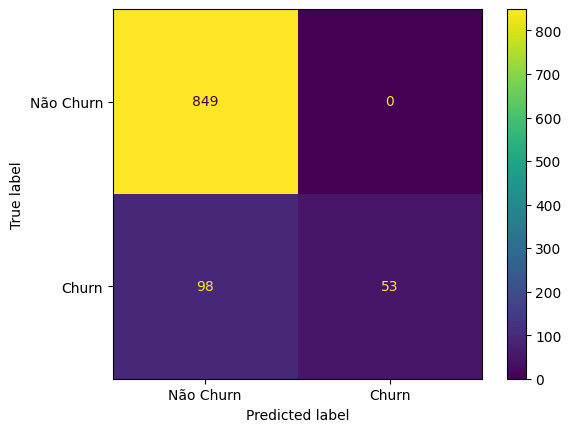

In [71]:
conf_matrix = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(conf_matrix, display_labels=['Não Churn', 'Churn'])
fig.plot()

In [72]:
print(f'Log Loss: {log_loss(y_test, y_pred_proba)}')

Log Loss: 0.23955724161353584


### TREINAR MODELO CROSS VALIDATION E TUNING DE HIPERPARAMETROS

In [73]:
# Dicionario de hiperparâmetros
params_grids = {
  'n_estimators': [100, 200, 300, 400, 500],
  'max_depth': [None, 10, 20, 30, 40, 50],
  'min_samples_split': [2, 5, 10, 20],
  'min_samples_leaf': [1, 2, 4, 5, 10],
}

In [77]:
rf_model_cv = RandomForestClassifier(random_state=42, class_weight='balanced', max_features='sqrt')
k_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(rf_model_cv, param_grid=params_grids, cv=k_folds, scoring='recall', verbose=2)

In [78]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 4, 5, 10],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='recall', verbose=2)

In [79]:
best_model = grid_search.best_estimator_

In [80]:
best_params = grid_search.best_params_

In [81]:
print(best_params)

{'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 300}


In [82]:
best_score = grid_search.best_score_
best_score

np.float64(0.6074074074074074)

In [83]:
y_pred = best_model.predict(X_test)

In [84]:
y_ped_proba = best_model.predict_proba(X_test)

In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       849
           1       0.99      0.59      0.74       151

    accuracy                           0.94      1000
   macro avg       0.96      0.79      0.85      1000
weighted avg       0.94      0.94      0.93      1000



In [86]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

In [88]:
fig = px.area(
  x=fpr,
  y=tpr,
  title=f'Curva ROC (AUC={roc_auc:.4f})',
  labels=dict(x='Taxa de Falso Positivo', y='Taxa de Verdadeiro Positivo'),
  width=800,
  height=800
)
fig.add_shape(
  type='line', line=dict(dash='dash'),
  x0=0, x1=1, y0=0, y1=1 
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

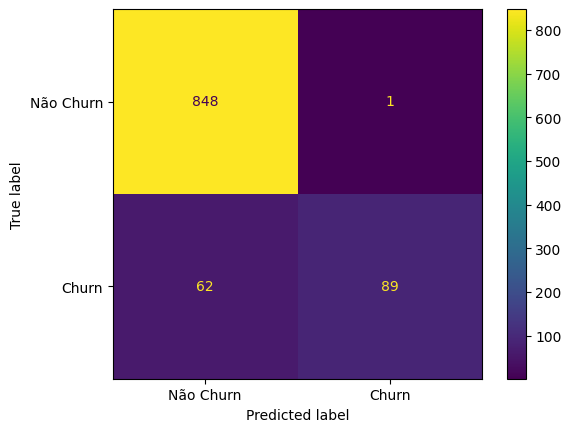

In [89]:
conf_matrix = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(conf_matrix, display_labels=['Não Churn', 'Churn'])
fig.plot()

### AJUSTAR THRESHOLD

In [101]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

recalls = []

for threshold in thresholds:
  y_pred_threshold = (y_pred_proba[:, 1] >= threshold).astype(int)
  recall = recall_score(y_test, y_pred_threshold)
  
  recalls.append(recall)

recalls

[0.9006622516556292,
 0.7682119205298014,
 0.6556291390728477,
 0.5099337748344371,
 0.36423841059602646,
 0.2251655629139073,
 0.08609271523178808]

In [93]:
df_trheadholds = pd.DataFrame({'thresholds': thresholds, 'recall': recalls})

In [94]:
df_trheadholds

,thresholds,recall
0,0.3,0.655629
1,0.4,0.509934
2,0.5,0.364238
3,0.6,0.225166
4,0.7,0.086093


In [102]:
y_pred = (y_pred_proba[:, 1] >= 0.1).astype(int)

In [103]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.71      0.82       849
           1       0.36      0.90      0.51       151

    accuracy                           0.74      1000
   macro avg       0.67      0.81      0.67      1000
weighted avg       0.88      0.74      0.78      1000



In [104]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

In [105]:
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

In [106]:
fig = px.area(
  x=fpr,
  y=tpr,
  title=f'Curva ROC (AUC={roc_auc:.4f})',
  labels=dict(x='Taxa de Falso Positivo', y='Taxa de Verdadeiro Positivo'),
  width=800,
  height=800
)
fig.add_shape(
  type='line', line=dict(dash='dash'),
  x0=0, x1=1, y0=0, y1=1 
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

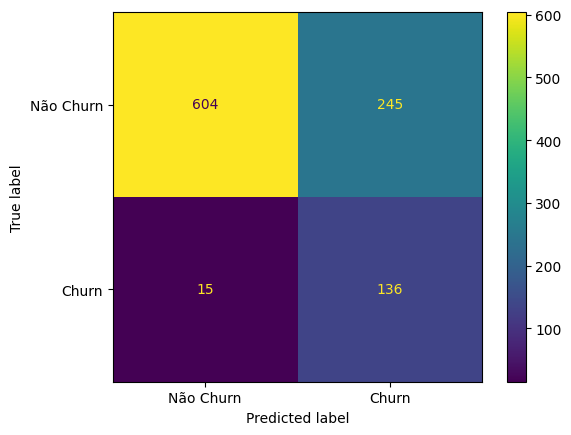

In [107]:
conf_matrix = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(conf_matrix, display_labels=['Não Churn', 'Churn'])
fig.plot()